<a href="https://colab.research.google.com/github/alex-punchenko/my_work/blob/main/feature_engineering_and_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EDA and feature engineering**

# Получение данных и импорт стартовых библиотек.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
print(fetch_california_housing().DESCR) #ниформация о наборе данных

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [ ]:
df = fetch_california_housing(as_frame=True).frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
df.shape

(20640, 9)

# Поиск и обработка пропусков

Пропусков нет

In [ ]:
df.isna().agg(['mean', 'sum']).T

,mean,sum
MedInc,0.0,0.0
HouseAge,0.0,0.0
AveRooms,0.0,0.0
AveBedrms,0.0,0.0
Population,0.0,0.0
AveOccup,0.0,0.0
Latitude,0.0,0.0
Longitude,0.0,0.0
MedHouseVal,0.0,0.0


# Разделение выборки на обучающее и тестовое подмножества. В соотношении 80% на 20% соответственно.



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x =  df.drop(columns='MedHouseVal')
y = df['MedHouseVal']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Построение модели линейной регрессии.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(x_train,y_train)

LinearRegression()

In [ ]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

## Оценка качества модели

In [ ]:
from sklearn.metrics import r2_score, root_mean_squared_error

In [ ]:
print(f'RMSE train = {round(root_mean_squared_error(y_train,y_pred_train), 3)}')
print(f'RMSE test = {round(root_mean_squared_error(y_test,y_pred_test), 3)}')

RMSE train = 0.723
RMSE test = 0.727


In [ ]:
print(f'R2 train = {round(r2_score(y_train,y_pred_train), 3)}')
print(f'R2 test = {round(r2_score(y_test,y_pred_test), 3)}')

R2 train = 0.608
R2 test = 0.597


In [ ]:
pd.DataFrame(model.coef_,df.columns[0:-1]).sort_values(by=0,ascending=False)

,0
AveBedrms,0.632189
MedInc,0.438565
HouseAge,0.009687
Population,-0.000004
AveOccup,-0.003448
AveRooms,-0.104705
Latitude,-0.425964
Longitude,-0.440601


# График распределения целевой переменной

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

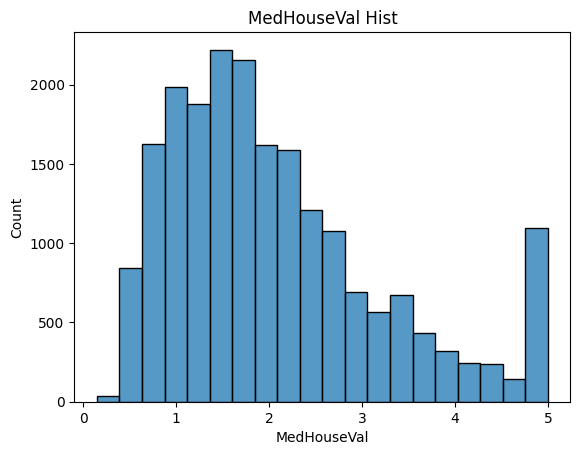

In [ ]:
sns.histplot(df['MedHouseVal'],bins=20)
plt.title('MedHouseVal Hist')
plt.show()

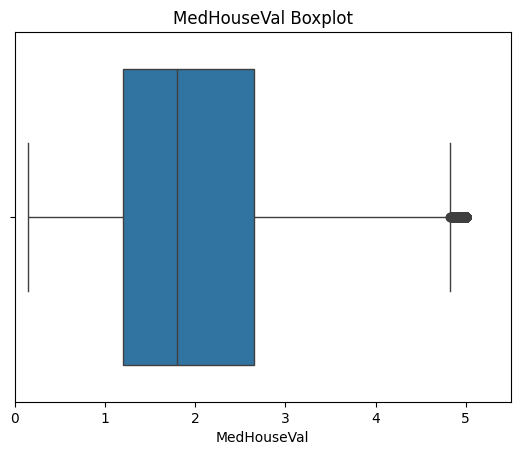

In [ ]:
sns.boxplot(df['MedHouseVal'], orient='h')
plt.xlim(0, 5.5)
plt.title('MedHouseVal Boxplot')
plt.show()

In [ ]:
q1 = np.percentile(df['MedHouseVal'], 25)
q3 = np.percentile(df['MedHouseVal'], 75)
iqr = q3 - q1

(df['MedHouseVal'] > (q3 + 1.5 * iqr)).mean() #доля 3Q + 1.5 * IQR

0.05188953488372093

In [ ]:
(df['MedHouseVal'] > (q3 + 1.65 * iqr)).mean() #доля 3Q + 1.65 * IQR

0.0

Около 5% данных выходят за 3Q + 1.5 * IQR\
Однако они не находятся далеко(до 3Q + 1.65 * IQR)\
Не считаю их выбросами.\
 **Вывод: существенных выбросов не наблюдается.**

# EDA + feature engineering

In [ ]:
data_processed = df.copy()
tmp = data_processed.copy()

## Функция для оценки качества модели

Для удобства работы далее, создам функцию оценки качества модели.

In [ ]:
def get_score(df, model = LinearRegression()):
    '''
    Функция подсчета качества модели.
    На вход подается датафрейм (df),
    Модель обучения (model). По умолчанию LinearRegression().
    Возвращает словарь со значениями метрик RMSE_train, RMSE_test, R2_train, R2_test
    Пример вывода:
     {'RMSE_train': 0.723, 'RMSE_test': 0.727, 'R2_train': 0.608, 'R2_test': 0.597}
    '''

    x =  df.drop(columns='MedHouseVal')
    y = df['MedHouseVal']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    model.fit(x_train,y_train)

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    return {
    'RMSE_train': round(root_mean_squared_error(y_train, y_pred_train), 3),
    'RMSE_test': round(root_mean_squared_error(y_test, y_pred_test), 3),
    'R2_train' : round(r2_score(y_train,y_pred_train), 3),
    'R2_test' : round(r2_score(y_test,y_pred_test), 3)
}


In [ ]:
get_score(df)

{'RMSE_train': 0.723, 'RMSE_test': 0.727, 'R2_train': 0.608, 'R2_test': 0.597}

## Расчет корреляции и визуализация корреляционной матрицы.


In [ ]:
cor_matrix = df.corr().round(2)
cor_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.00,-0.12,0.33,-0.06,0.00,0.02,-0.08,-0.02,0.69
HouseAge,-0.12,1.00,-0.15,-0.08,-0.30,0.01,0.01,-0.11,0.11
AveRooms,0.33,-0.15,1.00,0.85,-0.07,-0.00,0.11,-0.03,0.15
AveBedrms,-0.06,-0.08,0.85,1.00,-0.07,-0.01,0.07,0.01,-0.05
Population,0.00,-0.30,-0.07,-0.07,1.00,0.07,-0.11,0.10,-0.02
AveOccup,0.02,0.01,-0.00,-0.01,0.07,1.00,0.00,0.00,-0.02
Latitude,-0.08,0.01,0.11,0.07,-0.11,0.00,1.00,-0.92,-0.14
Longitude,-0.02,-0.11,-0.03,0.01,0.10,0.00,-0.92,1.00,-0.05
MedHouseVal,0.69,0.11,0.15,-0.05,-0.02,-0.02,-0.14,-0.05,1.00


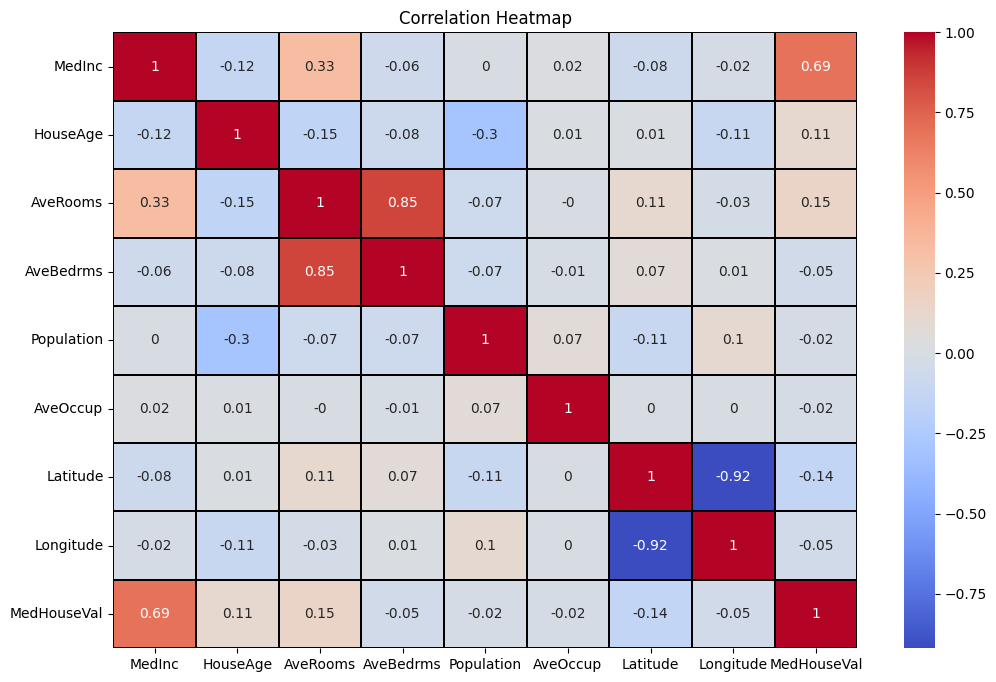

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix,annot=True,linewidths=0.05,linecolor='black',cmap="coolwarm")

plt.title("Correlation Heatmap")

plt.show()

## Объединение в кластеры по местоположению Latitude и Longitude.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=3,random_state=1)

cluster = kmeans.fit_predict(df[['Latitude', 'Longitude']])
tmp = data_processed.copy()
tmp['cluster'] = cluster



In [ ]:
get_score(data_processed)

{'RMSE_train': 0.723, 'RMSE_test': 0.727, 'R2_train': 0.608, 'R2_test': 0.597}

In [ ]:
get_score(tmp)

{'RMSE_train': 0.714, 'RMSE_test': 0.718, 'R2_train': 0.618, 'R2_test': 0.607}

Есть небольшое улучшение на RMSE и на R2. Сохраняю результат.

In [ ]:
data_processed = tmp.copy()

## Удаление Avebedrms

Для устранения мультиколлинеарности удалю один из сильно коллерирующих признаков AveBedrms.\
(AveBedrms и AveRms corr = 0.85)

In [ ]:
tmp.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,cluster
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1


In [ ]:
tmp.drop(columns='AveBedrms',inplace=True)

In [ ]:
get_score(data_processed)

{'RMSE_train': 0.714, 'RMSE_test': 0.718, 'R2_train': 0.618, 'R2_test': 0.607}

In [ ]:
get_score(tmp)

{'RMSE_train': 0.721, 'RMSE_test': 0.724, 'R2_train': 0.611, 'R2_test': 0.6}

In [ ]:
data_processed = tmp.copy()

In [ ]:
data_processed.head()

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,Longitude,MedHouseVal,cluster
0,8.3252,41.0,6.984127,322.0,2.555556,37.88,-122.23,4.526,1
1,8.3014,21.0,6.238137,2401.0,2.109842,37.86,-122.22,3.585,1
2,7.2574,52.0,8.288136,496.0,2.802260,37.85,-122.24,3.521,1
3,5.6431,52.0,5.817352,558.0,2.547945,37.85,-122.25,3.413,1
4,3.8462,52.0,6.281853,565.0,2.181467,37.85,-122.25,3.422,1


Заметно небольшое ухудшение качества модели. Тем не менее сохраню полученый результат т.к в перспективе устранение мультиколлинеарности может дать улучшение качества.

## Работа с выбросами

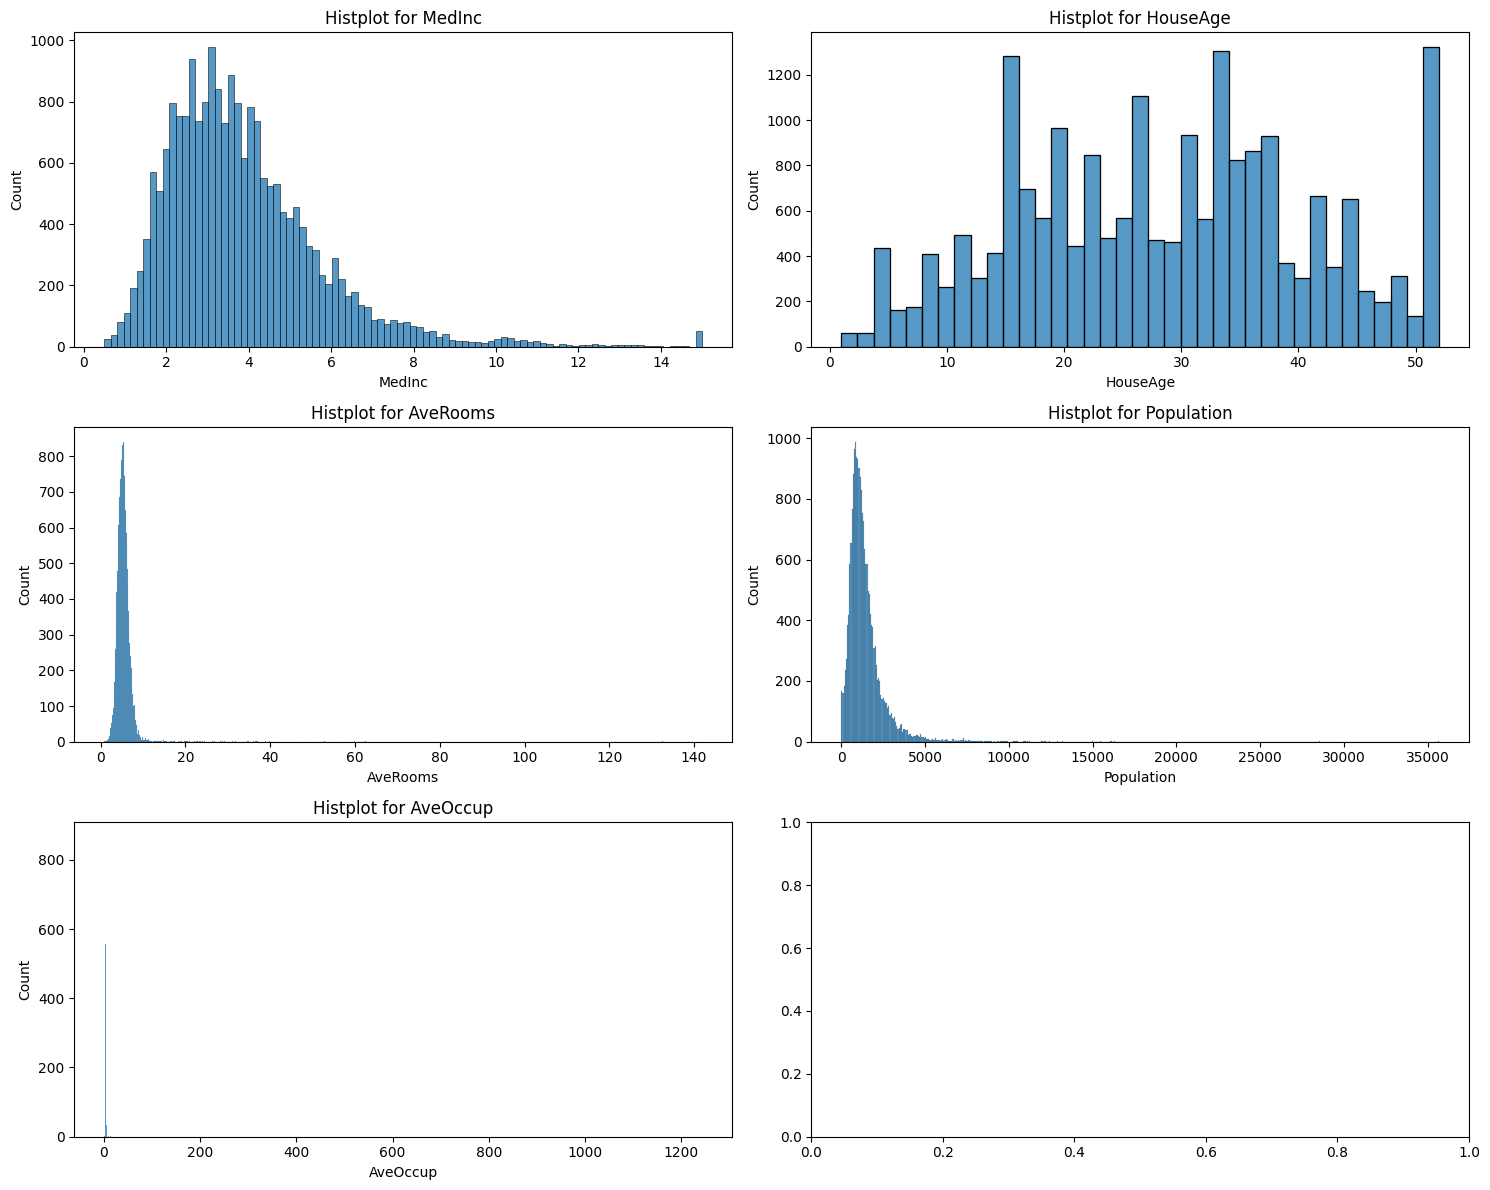

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, column in enumerate(data_processed.columns[:-4]):
    sns.histplot(data=df[column], ax=axes[i])
    axes[i].set_title(f"Histplot for {column}")


plt.tight_layout()
plt.show()

Резко выделяются выбросы в AveOccup. Колличество челенов семьи более 10 считаю выбросами

In [ ]:
len(data_processed[data_processed['AveOccup'] > 10])

37

In [ ]:
tmp = tmp[tmp['AveOccup'] < 10]

In [ ]:
get_score(data_processed)

{'RMSE_train': 0.721, 'RMSE_test': 0.724, 'R2_train': 0.611, 'R2_test': 0.6}

In [ ]:
get_score(tmp)

{'RMSE_train': 0.673, 'RMSE_test': 0.672, 'R2_train': 0.66, 'R2_test': 0.66}

In [ ]:
data_processed = tmp.copy() #сохраняю результат

Заметно улучшение результатов

Количество комнат так же имеет массу выбросов.\
За выбросы возьму значение > 20

In [ ]:
len(tmp[tmp['AveRooms'] > 20])

68

In [ ]:
tmp = tmp[tmp['AveRooms'] < 20]

In [ ]:
get_score(data_processed)

{'RMSE_train': 0.673, 'RMSE_test': 0.672, 'R2_train': 0.66, 'R2_test': 0.66}

In [ ]:
get_score(tmp)

{'RMSE_train': 0.675, 'RMSE_test': 0.656, 'R2_train': 0.659, 'R2_test': 0.675}

Так же получаю улучшение качества.

In [ ]:
data_processed = tmp.copy() #сохраняю результат

Аналогично удалю выбросы из колличества населения.

In [ ]:
len(tmp[tmp['Population'] > 10000])

23

In [ ]:
tmp = tmp[tmp['Population'] < 10000]

In [ ]:
get_score(data_processed)

{'RMSE_train': 0.675, 'RMSE_test': 0.656, 'R2_train': 0.659, 'R2_test': 0.675}

In [ ]:
get_score(tmp)

{'RMSE_train': 0.671, 'RMSE_test': 0.67, 'R2_train': 0.663, 'R2_test': 0.66}

В данном случае удаление привело к ухудшению качества. Отменяю удаление.

In [ ]:
tmp = data_processed.copy()

## Измение признаков  математически

Изменю значение количества населения на его логарифм.

In [ ]:
tmp['Population'] = np.log(tmp['Population'])

In [ ]:
get_score(data_processed)

{'RMSE_train': 0.675, 'RMSE_test': 0.656, 'R2_train': 0.659, 'R2_test': 0.675}

In [ ]:
get_score(tmp)

{'RMSE_train': 0.675, 'RMSE_test': 0.656, 'R2_train': 0.659, 'R2_test': 0.674}

Разницы практически нет.

In [ ]:
data_processed = tmp.copy() #сохраняю результат

Попробую возвести в степень количество комнат

In [ ]:
tmp['AveRooms^2'] = tmp['AveRooms'] ** 2
tmp['AveRooms^3'] = tmp['AveRooms'] ** 3

In [ ]:
get_score(data_processed)

{'RMSE_train': 0.675, 'RMSE_test': 0.656, 'R2_train': 0.659, 'R2_test': 0.674}

In [ ]:
get_score(tmp)

{'RMSE_train': 0.667, 'RMSE_test': 0.649, 'R2_train': 0.667, 'R2_test': 0.681}

In [ ]:
data_processed = tmp.copy() #сохраняю результат

Повторю тоже самое с количеством членов семьи.

In [ ]:
tmp['AveOccup^2'] = tmp['AveOccup'] ** 2
tmp['AveOccup^3'] = tmp['AveOccup'] ** 3

In [ ]:
get_score(data_processed)

{'RMSE_train': 0.667, 'RMSE_test': 0.649, 'R2_train': 0.667, 'R2_test': 0.681}

In [ ]:
get_score(tmp)

{'RMSE_train': 0.649, 'RMSE_test': 0.633, 'R2_train': 0.684, 'R2_test': 0.696}

In [ ]:
data_processed = tmp.copy() #сохраняю результат

# Вывод
Данный пример показывает на сколько важно выполнение преобразования признаков и EDA.\
Применив не самые сложные методы обработки данных удалось улучшить метрики \
**R2: с 0.597 до 0.696**\
**RMSE  c 0.727 до 0.633**

